In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import asyncio
import os
from collections import defaultdict
from dataclasses import dataclass, field
from datetime import datetime
from typing import Literal

import pandas as pd
from dotenv import load_dotenv
from dspy import LM, ChainOfThought, InputField, OutputField, Signature, configure
from fastembed import TextEmbedding
from IPython.display import Markdown, display
from langchain.schema import Document
from langchain.tools import tool
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import CSVLoader
from langchain_community.vectorstores import FAISS
from langchain_core.embeddings import Embeddings
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_deepseek import ChatDeepSeek
from langchain_experimental.text_splitter import SemanticChunker
from langchain_tavily import TavilySearch
from langgraph.graph import END, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langsmith import traceable
from loguru import logger
from pydantic import BaseModel, Field

from retriever_formatter import RetrieverReportGenerator
from source_formatter import SourceFormatter

In [3]:
# Load environment variables
_ = load_dotenv()

# Initialize LLM
llm = ChatDeepSeek(model="deepseek-chat")

# Load and prepare the dataset
df = pd.read_csv("data/hiv_aids_prevalence_africa.csv")
df["Article"] = df["Title"].str.cat(df["Abstract"].fillna(""), sep=".\n ")
df.drop(columns=["Abstract"], inplace=True)
df.to_csv("data/tests.csv", index=False)

In [4]:
@dataclass
class FastEmbed(Embeddings):
    fe: TextEmbedding = field(default_factory=TextEmbedding)

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        return [emb.tolist() for emb in self.fe.embed(texts)]

    def embed_query(self, text: str) -> list[float]:
        return list(self.fe.embed([text]))[0].tolist()

In [5]:
embeddings = FastEmbed(
    TextEmbedding(
        model_name="sentence-transformers/all-MiniLM-L6-V2",
        cache_dir=os.path.expanduser("~/.cache/fastembed"),
        local_files_only=True,
    )
)

splitter = SemanticChunker(embeddings)

loader = CSVLoader(
    file_path="data/tests.csv",
    source_column="Pmid",
    content_columns=["Article"],
    metadata_columns=[
        "Pmid",
        "Title",
        "Url",
        "Authors",
        "Keywords",
        "Journal",
        "Affiliations",
        "Publication Date",
        "References",
    ],
)

documents = loader.load()
splitted_documents = splitter.split_documents(documents)

In [6]:
def batch_process(
    documents: list[Document],
    embeddings,
    persist_directory,
    batch_size=10,
):
    # Check if the persist directory exists
    if not os.path.exists(persist_directory):
        logger.warning(
            f"Persist directory {persist_directory} does not exist. Creating it"
        )
        os.makedirs(persist_directory, exist_ok=True)

    # Create the batches
    batch_docs = [
        documents[i : i + batch_size] for i in range(0, len(documents), batch_size)
    ]

    if os.path.exists(os.path.join(persist_directory, "index.faiss")):
        logger.info(
            f"Vector Index already exists. Loading it from {persist_directory}."
        )
        vector_index = FAISS.load_local(
            persist_directory,
            embeddings=embeddings,
            allow_dangerous_deserialization=True,
        )
    else:
        logger.info("Creating new FAISS index from documents")
        # Create the vector_store
        vector_index = FAISS.from_documents(batch_docs[0], embeddings)

        for batch in batch_docs[1:]:
            vector_index.add_documents(batch)

        # Persist the index
        vector_index.save_local(persist_directory)

    return vector_index

In [7]:
embedding_model = FastEmbed(
    TextEmbedding(
        model_name="jinaai/jina-embeddings-v2-base-en",
        cache_dir=os.path.expanduser("~/.cache/fastembed"),
        local_files_only=True,
    )
)

In [8]:
vector_store = batch_process(
    splitted_documents, embedding_model, persist_directory="../faiss_index"
)

2025-09-05 20:09:35.431 | INFO     | __main__:batch_process:20 - Vector Index already exists. Loading it from ../faiss_index.


In [9]:
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

results = retriever.invoke(
    "What strategies are suggested to reduce HIV prevalence among dialysis patients worldwide?"
)

In [18]:
@tool
def retriever_tool(query):
    """
    Retrieves pubmed data using the provided query and generates a report in markdown format.

    This function utilizes a retriever to invoke the given query, processes the response,
    and generates a report in markdown format using a report generator.

    Args:
        query: The query string to retrieve data.

    Returns:
        str: A markdown formatted report generated based on the retriever's response.
    """
    response =  retriever.invoke(query)
    report_gen = RetrieverReportGenerator()
    markdown, _, _ = report_gen.create_report(response)
    return markdown

In [11]:
class StructuredOutput(BaseModel):
    answer: list[str] = Field(description="A List of search queries")


dspy_lm = LM(
    "deepseek/deepseek-chat",
    api_key=os.getenv("DEEPSEEK_API_KEY"),
    base_url="https://api.deepseek.com",
)
configure(lm=dspy_lm)


class MultiQueryGenerator(Signature):
    """Generate multiple research queries from a single user query."""

    question = InputField(desc="Original user query")
    num_queries = InputField(desc="Number of research queries to generate")
    research_queries: StructuredOutput = OutputField(
        desc="Generate a list of search terms to for the questions to aid in web search for an AI agent"
    )


query_optimizer = ChainOfThought(MultiQueryGenerator)


@traceable(name="query_generator")
def query_generator(question: str, num_queries: int):
    try:
        return query_optimizer(
            question=question, num_queries=num_queries
        ).research_queries.answer
    except Exception as e:
        print(f"An error occurred during query generation: {e}")
        return []

In [37]:
async def tavily_search_async(
    search_query: str,
    max_results: int = 5,
    num_queries: int = 5,
    include_raw_content: bool = False,
    topic: Literal["general", "news", "finance"] = "general",
):
    tavily_search = TavilySearch(
        max_results=max_results, include_raw_content=include_raw_content, topic=topic
    )

    search_queries = query_generator(search_query, num_queries)
    tasks = [tavily_search.ainvoke({"query": q}) for q in search_queries]
    results = await asyncio.gather(*tasks)
    return results

In [16]:

@tool
async def web_search(search_query: str):
    """
    Search the web for the given search queries.
    """
    formatter = SourceFormatter(
    markdown_output=False
) 
    search_response = await tavily_search_async(
        search_query, max_results=5, include_raw_content=True
    )

    deduplicated_response = formatter.deduplicate_and_format_sources(search_response)
    return deduplicated_response

In [17]:
tools = [retriever_tool, web_search]  # TODO: Add the web search tool

llm_with_tools = llm.bind_tools(tools)

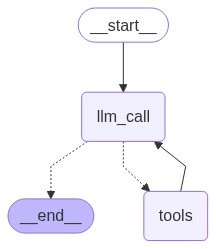

In [40]:
rag_prompt = """
You are a helpful medical research assistant with access to two information sources:

1. **Primary Source - PubMed Retriever**: Always start here to search your indexed PubMed database for relevant medical literature, abstracts, and research findings.

2. **Secondary Source - Tavily Web Search**: Only use this if PubMed retrieval yields insufficient information or if current/breaking medical news is needed.

**Process:**
- Begin every query by using the PubMed retriever tool first
- Evaluate if the retrieved PubMed content sufficiently answers the user's question
- If PubMed results are sparse, outdated, or incomplete, then supplement with Tavily search
- Always prioritize peer-reviewed medical literature over general web content
- Cite all sources with proper references
- Synthesize findings into accurate, evidence-based responses
- If neither source provides adequate information, clearly state the limitations

Always clarify the user's research question or scope before retrieving, and continue gathering information until you have sufficient coverage to provide a thorough, well-supported answer.
"""


class State(MessagesState):
    texts: str


def llm_call(state: State):
    messages = state.get("messages", [])

    # If no messages yet, start the conversation
    if not messages:
        messages = [
            SystemMessage(content=rag_prompt),
            HumanMessage(content=state["texts"]),
        ]

    response = llm_with_tools.invoke(messages)
    return {"messages": messages + [response]}


# state = State(texts="What are the approaches to Task Decomposition?")
graph = StateGraph(State)
graph.add_node("llm_call", llm_call)
graph.add_node("tools", ToolNode(tools))

graph.set_entry_point("llm_call")
graph.add_conditional_edges(
    "llm_call", tools_condition, {"tools": "tools", "__end__": END}
)
graph.add_edge("tools", "llm_call")

full_graph = graph.compile()
full_graph

In [41]:
state = State(texts="What strategies are suggested to reduce HIV prevalence among dialysis patients worldwide?")
result = full_graph.invoke(state)

print(result["messages"][-1].content)  # Final assistant answer

Based on the research findings from PubMed, I can provide you with evidence-based strategies to reduce HIV prevalence among dialysis patients worldwide. Here are the key strategies supported by the medical literature:

## Key Strategies to Reduce HIV Prevalence Among Dialysis Patients

### 1. **Strict Infection Control Protocols**
- **Universal Precautions**: Implement and strictly enforce standard infection control measures in all dialysis centers
- **Proper Sterilization**: Ensure thorough sterilization of dialysis equipment between patients
- **Environmental Controls**: Maintain clean treatment environments with proper disinfection protocols

### 2. **Enhanced Healthcare Infrastructure**
- **Resource Allocation**: Invest in adequate healthcare facilities and equipment, particularly in high-prevalence regions like Africa and North America
- **Staff Training**: Provide comprehensive training for dialysis center staff on HIV prevention and infection control
- **Regular Audits**: Conduc